In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"enfalelgrm","key":"f41a44cdfc3b41764e952e1bbeccfa3c"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!pip install -q kaggle
!kaggle competitions download -c dogs-vs-cats


100% 810M/812M [00:04<00:00, 113MB/s] 
100% 812M/812M [00:04<00:00, 173MB/s]


In [ ]:
!mkdir -p data/train


In [ ]:
!unzip -q dogs-vs-cats.zip -d data
!unzip -q data/train.zip -d data/train


In [ ]:
import os, shutil

base_dir = 'data'
train_dir = os.path.join(base_dir, 'train')
cat_dir = os.path.join(base_dir, 'cats')
dog_dir = os.path.join(base_dir, 'dogs')

os.makedirs(cat_dir, exist_ok=True)
os.makedirs(dog_dir, exist_ok=True)

for fname in os.listdir(train_dir):
    if fname.startswith('cat'):
        shutil.move(os.path.join(train_dir, fname), os.path.join(cat_dir, fname))
    elif fname.startswith('dog'):
        shutil.move(os.path.join(train_dir, fname), os.path.join(dog_dir, fname))



In [ ]:
from sklearn.model_selection import train_test_split

def split_data(source_dir, train_dir, val_dir, split_size=0.8):
    files = os.listdir(source_dir)
    train_files, val_files = train_test_split(files, train_size=split_size, random_state=42)

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    for file in train_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(train_dir, file))
    for file in val_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(val_dir, file))

split_data(cat_dir, 'data/train/cats', 'data/val/cats')
split_data(dog_dir, 'data/train/dogs', 'data/val/dogs')



In [ ]:
import os, shutil

wrong_dir = 'data/train/train'
correct_dir = 'data/train'

for fname in os.listdir(wrong_dir):
    shutil.move(os.path.join(wrong_dir, fname), os.path.join(correct_dir, fname))

os.rmdir(wrong_dir)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    'data/train',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

val_data = val_datagen.flow_from_directory(
    'data/val',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [ ]:
model.save("cats_vs_dogs_model.h5")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!cp cats_vs_dogs_model.h5 /content/drive/MyDrive/


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5
)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 505s 805ms/step - accuracy: 0.5901 - loss: 0.7403 - val_accuracy: 0.6808 - val_loss: 0.6184
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 502s 804ms/step - accuracy: 0.7387 - loss: 0.5205 - val_accuracy: 0.7512 - val_loss: 0.5094
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 558s 798ms/step - accuracy: 0.8011 - loss: 0.4305 - val_accuracy: 0.7756 - val_loss: 0.4781
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 503s 805ms/step - accuracy: 0.8572 - loss: 0.3281 - val_accuracy: 0.7780 - val_loss: 0.4981
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 506s 809ms/step - accuracy: 0.9157 - loss: 0.2098 - val_accuracy: 0.7596 - val_loss: 0.6256


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


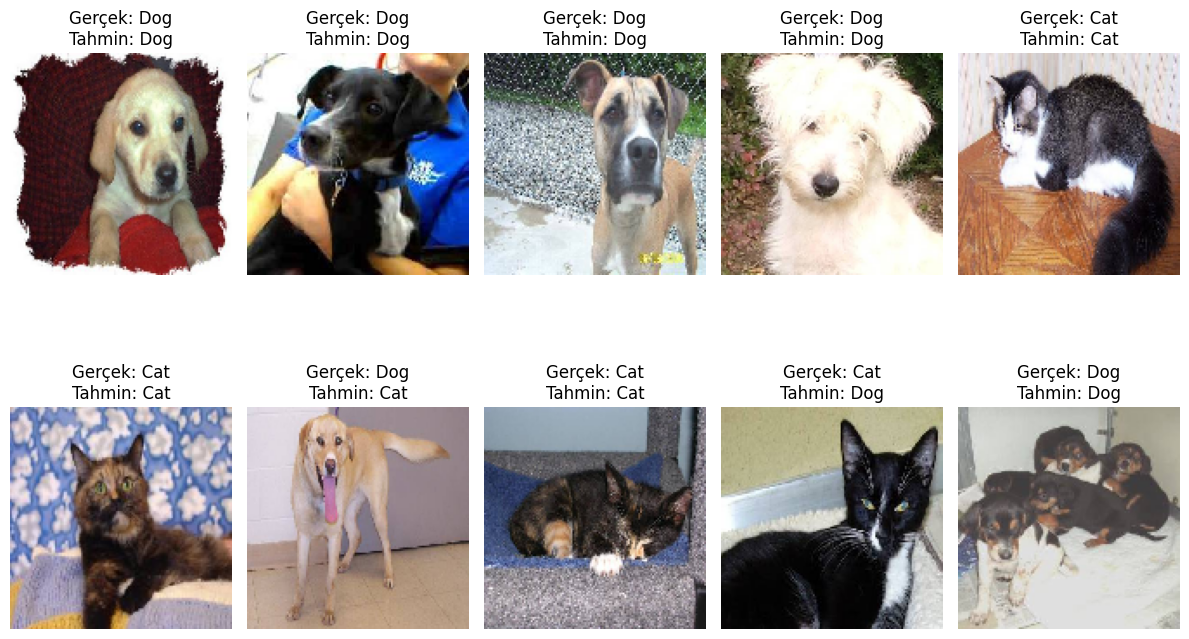

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

sample_batch = next(iter(val_data))
images, labels = sample_batch

predictions = model.predict(images)
predicted_classes = (predictions > 0.5).astype("int32")

plt.figure(figsize=(12, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f"Gerçek: {'Dog' if labels[i] else 'Cat'}\nTahmin: {'Dog' if predicted_classes[i] else 'Cat'}")
    plt.axis('off')

plt.tight_layout()
plt.show()
